# Masking grid cells

This notebook will demostate the following:

  1. Reading boundary, river, and island data from shapefiles
  2. Generating a focused grid
  3. Masking land cells from the shapefiles
  4. Writing grid data to shapefiles


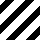
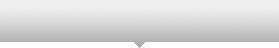
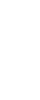
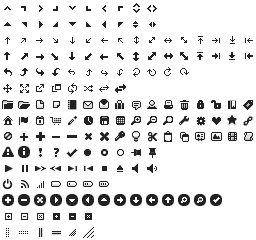
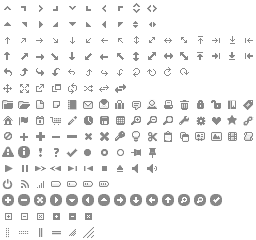
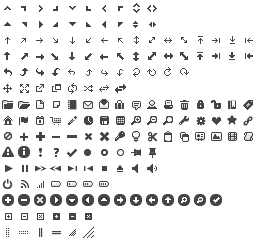
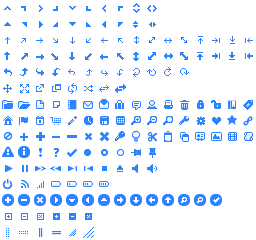
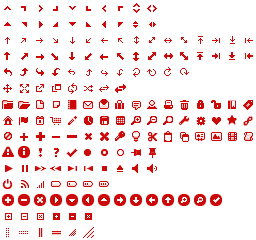
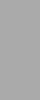
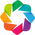
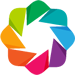
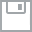
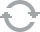
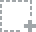
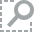
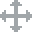
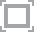
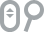

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn

import pygridgen
import pygridtools as pgt

seaborn.set(style='white')
%matplotlib inline

## Load the grid boundary, river, and islands using `pygridtools.io`

(<matplotlib.figure.Figure at 0x7f0cb6ce1390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0cb6c71fd0>)

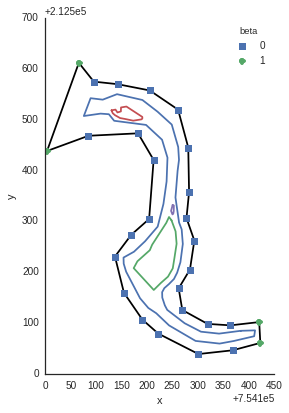

In [2]:
boundaryfile = "masking_data/input/GridBoundary.shp"
gridbounds = pgt.io.loadBoundaryFromShapefile(
    boundaryfile, 
    sortcol='sort_order', 
    upperleftcol='upper_left'
)

riverfile = "masking_data/input/River.shp"
river = pgt.io.loadPolygonFromShapefile(riverfile)

islandfile = "masking_data/input/Islands.shp"
islands = pgt.io.loadPolygonFromShapefile(islandfile)

fg = pgt.viz.plotReachDF(gridbounds, 'x', 'y', 'reach')
fg.fig.set_size_inches(6, 6)
pgt.viz.plotBoundaries(river=river, islands=islands, ax=fg.axes[0, 0], engine='mpl')

## Create a `Gridgen` object and convert to a `ModelGrid`

In [3]:
# number of nodes in each dimension
nx = 100
ny = 20

# grid focus
focus = pygridgen.Focus()

# tighten the grid in the channels around the big island
focus.add_focus_y(5./ny, 4., Ry=8./ny)
focus.add_focus_y(14.5/ny, 4., Ry=4./ny)

# coarsen the grid upstream
focus.add_focus_x(98./nx, 0.25, Rx=4./nx)

# tighten the grid around the big island's bend
focus.add_focus_x(52./nx, 4., Rx=20./nx)

# generate the main grid
raw_grid, fig = pgt.makeGrid(
    coords=gridbounds, 
    plot=False, 
    nx=nx, 
    ny=ny,
    focus=focus
)

# convert to a "ModelGrid"
grid = pgt.ModelGrid.from_Gridgen(raw_grid)

/home/paul/miniconda/envs/grid/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## Show the raw (unmasked grid)

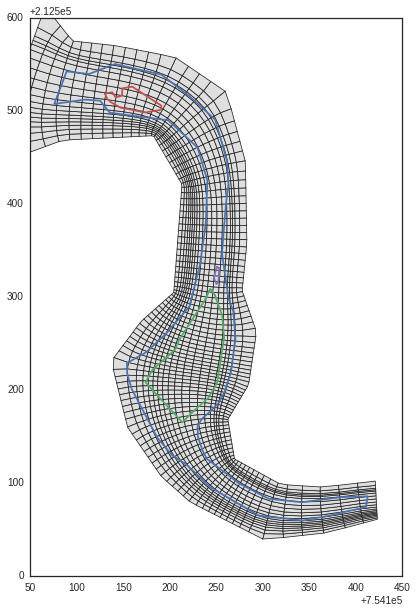

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
grid.plotCells(boundary=gridbounds, river=river, islands=islands, ax=ax)
ax.grid(False)
ax.set_aspect('equal')

## Mask out everything beyond the river banks

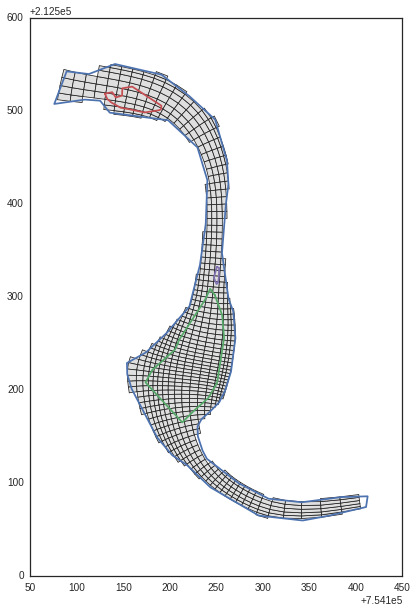

In [5]:
# outside the banks
grid.mask_cells_with_polygon(river, inside=False)

fig, ax = plt.subplots(figsize=(10,10))
grid.plotCells(boundary=gridbounds, river=river, islands=islands, ax=ax)
ax.grid(False)
ax.set_aspect('equal')

## Loop through and mask out the islands

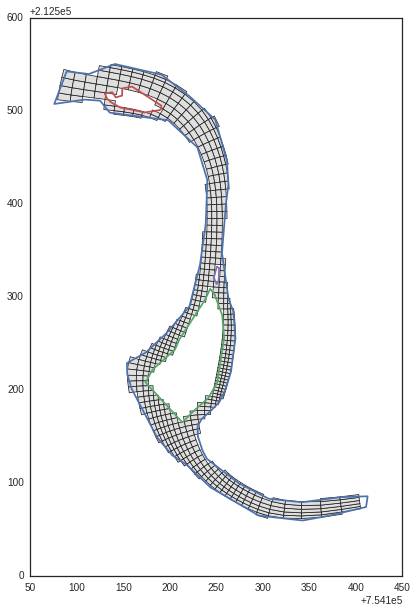

In [6]:
# inside the multiple islands
for island in islands:
    grid.mask_cells_with_polygon(island, inside=True)
    
fig, ax = plt.subplots(figsize=(10,10))
grid.plotCells(boundary=gridbounds, river=river, islands=islands, ax=ax)
ax.grid(False)
ax.set_aspect('equal')

## Export the masked cells to a shapefile

In [7]:
template = 'masking_data/input/cell_template.shp'
grid.to_shapefile('masking_data/output/ModelCells.shp', usemask=True, 
                  which='grid', geom='Polygon', 
                  template=template)

## View the final input and output in the QGIS file in `examples/masking_data/Grid.qgs`